In [1]:
import glob
import os
import cv2
import glob
import re
import json
import h5py

import matplotlib as mpl
import tifffile as tf
import pandas as pd
import pylab as pl
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy import misc,interpolate,stats,signal


In [2]:
%matplotlib notebook

In [3]:
# -----------------------------------------------------------------------------
# Commonly used, generic methods:
# -----------------------------------------------------------------------------
def get_pixel_size():
    # Use measured pixel size from PSF (20191005, most recent)
    # ------------------------------------------------------------------
    xaxis_conversion = 2.3 #1  # size of x-axis pixel, goes with A-P axis
    yaxis_conversion = 1.9 #89  # size of y-axis pixels, goes with M-L axis
    return (xaxis_conversion, yaxis_conversion)


def label_figure(fig, data_identifier):
    fig.text(0, 1,data_identifier, ha='left', va='top', fontsize=8)

def convert_range(oldval, newmin=None, newmax=None, oldmax=None, oldmin=None):
    oldrange = (oldmax - oldmin)
    newrange = (newmax - newmin)
    newval = (((oldval - oldmin) * newrange) / oldrange) + newmin
    return newval

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]


In [4]:
# from scipy import misc,interpolate,stats,signal
def smooth_array(inputArray, fwhm, phaseArray=False):
    szList=np.array([None,None,None,11,None,21,None,27,None,31,None,37,None,43,None,49,None,53,None,59,None,55,None,69,None,79,None,89,None,99])
    sigmaList=np.array([None,None,None,.9,None,1.7,None,2.6,None,3.4,None,4.3,None,5.1,None,6.4,None,6.8,None,7.6,None,8.5,None,9.4,None,10.3,None,11.2,None,12])
    sigma=sigmaList[fwhm]
    sz=szList[fwhm]
    #print(sigma, sz)
    if phaseArray:
        outputArray = smooth_phase_array(inputArray,sigma,sz)
    else:
        outputArray=cv2.GaussianBlur(inputArray, (sz,sz), sigma, sigma)
        
    return outputArray
        
def smooth_phase_array(theta,sigma,sz):
    #build 2D Gaussian Kernel
    kernelX = cv2.getGaussianKernel(sz, sigma); 
    kernelY = cv2.getGaussianKernel(sz, sigma); 
    kernelXY = kernelX * kernelY.transpose(); 
    kernelXY_norm=np.true_divide(kernelXY,np.max(kernelXY.flatten()))
    
    #get x and y components of unit-length vector
    componentX=np.cos(theta)
    componentY=np.sin(theta)
    
    #convolce
    componentX_smooth=signal.convolve2d(componentX,kernelXY_norm,mode='same',boundary='symm')
    componentY_smooth=signal.convolve2d(componentY,kernelXY_norm,mode='same',boundary='symm')

    theta_smooth=np.arctan2(componentY_smooth,componentX_smooth)
    return theta_smooth


# def process_maps(mapdata, smooth_fwhm=None, mag_thr=None, recenter=True, mask_mag=True):
#     phase_az = mapdata['phaseMap'].copy()
#     mag_az = mapdata['magRatioMap'].copy()
    
#     # phase_az[mag_az<mag_thr]=np.nan

#     if smooth_fwhm is not None:
#         phase_az =smooth_array(phase_az, smooth_fwhm, phaseArray=True)
#         mag_az = smooth_array(mag_az, smooth_fwhm)

#     if recenter:
#         phaseC_az = shift_map(phase_az)
#         phasemin = 0
#         phasemax = 2*np.pi
#     else:
#         phaseC_az = np.copy(phase_az)
#         phasemin = -np.pi
#         phasemax = np.pi

#     phaseC_az[mag_az<mag_thr]=np.nan
    
#     magC_az = mag_az.copy()
#     if mask_mag:
#         magC_az[mag_az<mag_thr]=np.nan
    
#     return phaseC_az, magC_az, phasemin, phasemax

def shift_map(phase_az):
    phaseC_az=np.copy(phase_az)
    if phase_az[~np.isnan(phase_az)].min() < 0 and phase_az[~np.isnan(phase_az)].max() > 0:
        phaseC_az[phase_az<0]=-phase_az[phase_az<0]
        phaseC_az[phase_az>0]=(2*np.pi)-phase_az[phase_az>0]
    else:
        print("Already non-negative (min/max: %.2f, %.2f)" % (phase_az.min(), phase_az.max()))
    return phaseC_az


In [5]:
def convert_to_absolute(cond_data, smooth_fwhm=7, smooth=True, power_metric='mag'):
    '''combine absolute, or shift single-cond map so that
    
    if AZI, 0=left, 2*np.pi=right 
    if ALT, 0=bottom 2*np.pi= top
    
    Use this to convert to linear coords, centered around 0.
    power_metric: can be 'mag' or 'magRatio' (for Map type saved in analyzed maps).
    '''
    vmin = 0
    vmax = 2*np.pi

    combined_phase_map = convert_absolute_phasemap(cond_data, smooth_fwhm=smooth_fwhm, smooth=smooth)
    combined_mag_map =  convert_absolute_magmap(cond_data, smooth_fwhm=smooth_fwhm, smooth=smooth, 
                                                power_metric=power_metric)
    return combined_phase_map, combined_mag_map #_shift



def convert_absolute_phasemap(cond_data, smooth_fwhm=7, smooth=True):
    '''combine absolute, or shift single-cond map so that
    
    if AZI, 0=left, 2*np.pi=right 
    if ALT, 0=bottom 2*np.pi= top
    
    Use this to convert to linear coords, centered around 0.
    
    power_metric: can be 'mag' or 'magRatio' (for Map type saved in analyzed maps).
    
    '''
    vmin = 0
    vmax = 2*np.pi

    if len(cond_data.keys()) > 1:
        print("True absolute")
        c1 = 'left' if 'left' in cond_data.keys() else 'top'
        c2 = 'right' if c1=='left' else 'bottom'
    
        # Phase maps
        if smooth:
            m1 = shift_map(smooth_array(cond_data[c1]['phaseMap'], smooth_fwhm, phaseArray=True))
            m2 = shift_map(smooth_array(cond_data[c2]['phaseMap'], smooth_fwhm, phaseArray=True))
        else:
            m1 = shift_map(cond_data[c1]['phaseMap'])
            m2 = shift_map(cond_data[c2]['phaseMap'])
            
        combined_phase_map = spstats.circmean(np.dstack([m1, m2]), axis=-1, low=vmin, high=vmax) 

    else:
        print("Single cond")
        if 'right' in cond_data.keys() and 'top' not in cond_data.keys():
            m1 = cond_data['right']['phaseMap'].copy()
            m2 = cond_data['right']['phaseMap'].copy()*-1
            
        elif 'top' in cond_data.keys() and 'right' not in cond_data.keys():
            m1 = cond_data['top']['phaseMap'].copy()
            m2 = cond_data['top']['phaseMap'].copy()*-1
            
        # Phase maps
        combined_phase_map = (m2-m1)/2.
        
        if smooth:
            combined_phase_map = smooth_array(combined_phase_map, smooth_fwhm, phaseArray=True)
        
        # Shift maps
        combined_phase_map = shift_map(combined_phase_map) # values should go from 0 to 2*pi        
    
    return combined_phase_map #_shift


def convert_absolute_magmap(cond_data, smooth_fwhm=7, smooth=True, power_metric='mag'):
    '''combine absolute, or shift single-cond map so that
    
    if AZI, 0=left, 2*np.pi=right 
    if ALT, 0=bottom 2*np.pi= top
    
    Use this to convert to linear coords, centered around 0.
    
    power_metric: can be 'mag' or 'magRatio' (for Map type saved in analyzed maps).
    
    '''
    if len(cond_data.keys()) > 1:
        print("True absolute")
        c1 = 'left' if 'left' in cond_data.keys() else 'top'
        c2 = 'right' if c1=='left' else 'bottom'
        
        # Mag maps
        if smooth:
            p1 = smooth_array(cond_data[c1]['%sMap' % power_metric], smooth_fwhm, phaseArray=False)
            p2 = smooth_array(cond_data[c2]['%sMap' % power_metric], smooth_fwhm, phaseArray=False)
        else:
            p1 = cond_data[c1]['%sMap' % power_metric]
            p2 = cond_data[c2]['%sMap' % power_metric]
            
        combined_mag_map = np.mean(np.dstack([p1, p2]), axis=-1)

    else:
        print("Single cond")
        if 'right' in cond_data.keys() and 'top' not in cond_data.keys():
            p1 = cond_data['right']['%sMap' % power_metric].copy()
            
        elif 'top' in cond_data.keys() and 'right' not in cond_data.keys():
            p1 = cond_data['top']['%sMap' % power_metric].copy()
        
        # Mag maps
        combined_mag_map = p1
        
        if smooth:
            combined_mag_map = smooth_array(combined_mag_map, smooth_fwhm, phaseArray=False)
        
    return combined_mag_map #_shift


# Source data paths

In [6]:
surface_basedir = '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant'

rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

# Widefield:
analysis_basedir = '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant'
analysis_subdirs = 'Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean'


# Select animalid

In [7]:
animalid = 'JC085' #'JC117' #'JC113' #'JC076'

# find sessions
found_sessions = np.unique([os.path.split(sesh)[-1].split('_')[0] \
                  for sesh in glob.glob(os.path.join(analysis_basedir, animalid, '2019*'))])
print('[%s]: Found %i sessions' % (animalid, len(found_sessions)))
for si, sesh in enumerate(found_sessions):
    print(si, sesh)
    

sesh = found_sessions[-1]
print(sesh)
surface_path = glob.glob(os.path.join(analysis_basedir, animalid, '%s*' % sesh, 'Surface', '*.png'))[0]
print(surface_path)
session = os.path.split(surface_path.split('/Surface')[0])[-1].split('_')[0]
data_id = '%s_%s' % (animalid, session)
print("DATA ID: %s" % data_id)

[JC085]: Found 2 sessions
0 20190619
1 20190620
20190620
/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC085/20190620_highres/Surface/16bitSurf.png
DATA ID: JC085_20190620


In [8]:
# surface_path = glob.glob(os.path.join(surface_basedir, animalid, '%s_high*' % session, 'Surface', '*.png'))[0]
surface_hd = cv2.imread(surface_path, -1)
print(surface_hd.shape)

surface_path2 = glob.glob(os.path.join(surface_basedir, animalid, '%s' % session, 'Surface', '*.png'))[0]
surface = cv2.imread(surface_path2, -1)
print(surface.shape)

widefield_d1, widefield_d2 = surface_hd.shape
print("Surface image (%i, %i | %s)" % (widefield_d1, widefield_d2, surface_hd.dtype))

(492, 656)
(164, 218)
Surface image (492, 656 | uint16)


<IPython.core.display.Javascript object>


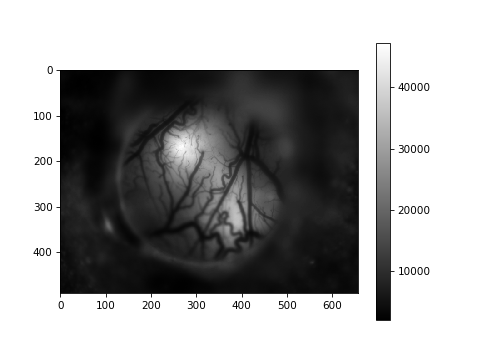

In [9]:
fig, ax = pl.subplots()
im = ax.imshow(surface_hd, cmap='gray', interpolation='nearest')
pl.colorbar(im)

# Load map arrays

In [10]:
#### Processed map data paths
# mappaths = glob.glob(os.path.join(analysis_basedir, animalid, '%s*' % session, analysis_subdirs, 'phase_decoding', 'Files', '*.npz'))
# mappaths
mappaths = glob.glob(os.path.join(analysis_basedir, animalid, '%s*' % session, 
                                  analysis_subdirs, 'phase_decoding', 'Files', '*.npz'))
for i, p in enumerate(mappaths):
    print(i, p)

condition_nums = {1: 'left',
                  2: 'right',
                  3: 'top',
                  4: 'bottom'}

condition_keys = {'azimuth': ['left', 'right'],
                  'altitude': ['top', 'bottom']}

mappath_d = {}
for mpath in mappaths:

    cond_name = re.findall(r'cond\d{1}_maps', mpath)[0]
    cond_num = int(re.findall(r'\d{1}', cond_name)[0])
    curr_cond = condition_nums[cond_num]
    
    mappath_d.update({curr_cond: mpath})
    

0 /n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC085/20190620/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20190620_cond2_maps.npz
1 /n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC085/20190620/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20190620_cond3_maps.npz


# Convert and process maps

In [11]:
mappath_d.keys()

dict_keys(['right', 'top'])

In [12]:
shift = True
smooth_fwhm = 7
smooth_first = True

vmin = 0 if shift else -np.pi
vmax = 2*np.pi if shift else np.pi

condition_keys = {'azimuth': ['left', 'right'],
                  'altitude': ['top', 'bottom']}

power_metric = 'mag'
alt_power_metric = 'magRatio' if power_metric=='mag' else 'mag'

mapdata = {}
all_mapdata = {}
for cond, bar_pos in condition_keys.items():
    
    cond_data = dict((bpos, np.load(mappath_d[bpos])) for bpos in bar_pos if bpos in mappath_d.keys())
    phasemap_, magmap_ = convert_to_absolute(cond_data, smooth_fwhm=smooth_fwhm, smooth=smooth_first,
                                            power_metric=power_metric)
    magmap_2 = convert_absolute_magmap(cond_data, smooth_fwhm=smooth_fwhm, smooth=smooth_first,
                                        power_metric=alt_power_metric)
    # Rescale if needed
    map_d1, map_d2 = phasemap_.shape
    resize_maps_d1 = widefield_d1/float(map_d1)
    resize_maps_d2 = widefield_d2/float(map_d2)

    if map_d1 != widefield_d1 or map_d2 != widefield_d2:
        phasemap_ = cv2.resize(phasemap_, (widefield_d2, widefield_d1), fx=resize_maps_d1, fy=resize_maps_d2)
        magmap_ = cv2.resize(magmap_, (widefield_d2, widefield_d1), fx=resize_maps_d1, fy=resize_maps_d2)
        magmap_2 = cv2.resize(magmap_2, (widefield_d2, widefield_d1), fx=resize_maps_d1, fy=resize_maps_d2)
    mapdata[cond] = {'phase': phasemap_, 
                     power_metric: magmap_,
                     alt_power_metric: magmap_2}    

    all_mapdata.update(cond_data)


Single cond
Single cond
Single cond
Single cond
Single cond
Single cond


In [13]:
cond_data

{'top': <numpy.lib.npyio.NpzFile at 0x2b4228181c50>}

In [14]:
# Widefield screenscreen_w, screen_h = (117, 67)
screen_w, screen_h = (117, 67)
screen_w_deg = screen_w/2.
screen_h_deg = screen_h/2.

print(screen_w_deg, screen_h_deg)

lmin_azi, lmax_azi = (-screen_w_deg, screen_w_deg)
lmin_alt, lmax_alt = (-screen_w_deg, screen_w_deg) #(-33.66, 33.66)
screen_h_min, screen_h_max = (-screen_h_deg, screen_h_deg)

print("Old min/max: %.2f, %.2f" % (vmin, vmax))
print("[AZI] New min/max: %.2f, %.2f" % (lmin_azi, lmax_azi))
print("[ALT] New min/max: %.2f, %.2f" % (lmin_alt, lmax_alt))


58.5 33.5
Old min/max: 0.00, 6.28
[AZI] New min/max: -58.50, 58.50
[ALT] New min/max: -58.50, 58.50


In [15]:
#### Linear range
azi_map = mapdata['azimuth']['phase'].copy() #mapdata['azimuth'].copy()
alt_map = mapdata['altitude']['phase'].copy()
azi_pwr = mapdata['azimuth']['%s' % power_metric]/mapdata['azimuth']['%s' % power_metric].max()
alt_pwr = mapdata['altitude']['%s' % power_metric]/mapdata['altitude']['%s' % power_metric].max()


azi_lin = convert_range(azi_map, newmin=lmin_azi, newmax=lmax_azi, oldmin=vmin, oldmax=vmax)
alt_lin = convert_range(alt_map, newmin=lmin_alt, newmax=lmax_alt, oldmin=vmin, oldmax=vmax)

print(azi_lin.min(), azi_lin.max())

-58.46026251923368 58.441660511014746


In [16]:
mag_thr=0.01
azi_mag = mapdata['azimuth']['magRatio'].copy()
alt_mag = mapdata['altitude']['magRatio'].copy()
azi_mag[azi_mag<mag_thr]= np.nan
alt_mag[alt_mag<mag_thr]= np.nan

<IPython.core.display.Javascript object>


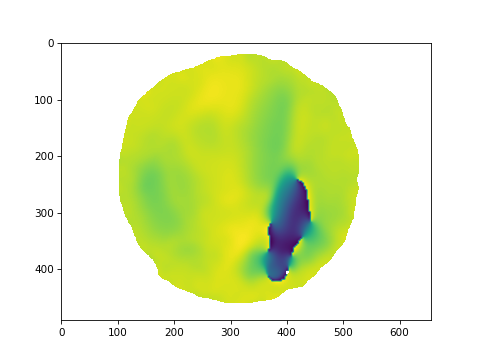

In [17]:
azi_lin[np.isnan(azi_mag)] = np.nan
alt_lin[np.isnan(azi_mag)] = np.nan

pl.figure()
pl.imshow(azi_lin)

# Select colormap

In [18]:
# Load colormap
colormap = 'romaO' #'nic_Edge' #'romaO'
cmapdir = '/n/coxfs01/julianarhee/colormaps'
cdata = np.loadtxt(os.path.join(cmapdir, colormap) + ".txt")
cmap_phase = LinearSegmentedColormap.from_list('my_colormap', cdata[::-1])


# PLOT.

<IPython.core.display.Javascript object>


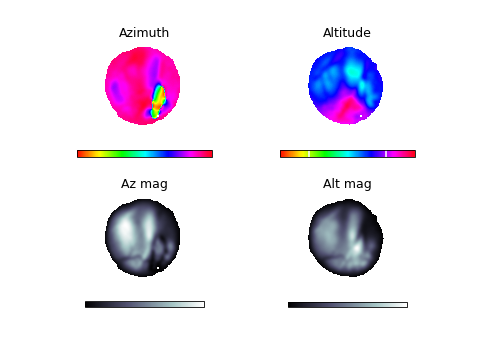

In [19]:
az_wf = azi_lin.copy()
az_wf[np.isnan(azi_mag)] = np.nan

el_wf = alt_lin.copy()
el_wf[np.isnan(alt_mag)] = np.nan

cmap='hsv'

fig = pl.figure()

fig.add_subplot(221)
pl.title('Azimuth')
pl.imshow(az_wf, cmap=cmap, vmin=lmin_azi, vmax=lmax_azi)
pl.colorbar(orientation='horizontal', shrink=0.8)

fig.add_subplot(222)
pl.title('Altitude')
pl.imshow(el_wf, cmap=cmap, vmin=lmin_alt, vmax=lmax_alt)
cb = pl.colorbar(orientation='horizontal', shrink=0.8)

screen_lim_pos = screen_h_max/lmax_alt #(lmax_alt-screen_h_max)/(lmax_alt*2.)
# cb.ax.plot(screen_lim_pos*lmax_alt, 0.5, 'w.') # my data is between 0 and 1
# cb.ax.plot(screen_lim_pos*lmin_alt, 0.5, 'w.') # my data is between 0 and 1
cb.ax.axvline(x=screen_lim_pos*lmax_alt, color='w') # my data is between 0 and 1
cb.ax.axvline(x=screen_lim_pos*lmin_alt, color='w') # my data is between 0 and 1

# cb.ax.axvline(x=screen_h_min, c='w')          # line at 3

# for ax in fig.axes:
#     ax.axis('off')


fig.add_subplot(223)
pl.title('Az mag')
pl.imshow(azi_mag, cmap='bone') #, vmin=lmin_alt, vmax=lmax_alt)
cb = pl.colorbar(orientation='horizontal', shrink=0.7)


fig.add_subplot(224)
pl.title('Alt mag')
pl.imshow(alt_mag, cmap='bone') #, vmin=lmin_alt, vmax=lmax_alt)
cb = pl.colorbar(orientation='horizontal', shrink=0.7)
# cb.ax.set_ticks(np.linspace(0, 0.15, 3))


for ax in fig.axes:
    ax.axis('off')

In [44]:
lmin_alt, lmax_alt

(-58.5, 58.5)

# 2p data

In [21]:
import pandas as pd

In [22]:
def get_final_maps(magratios_soma, phases_soma, trials_by_cond=None, mag_thr=0.01, delay_thr=0.5,
                   dims=(512, 512), ds_factor=2, use_pixels=False):
    
    # Get absolute maps from conditions
    magmaps, absolute_az, absolute_el, delay_az, delay_el = absolute_maps_from_conds(
                                                        magratios_soma, phases_soma, trials_by_cond=trials_by_cond,
                                                        mag_thr=magthr_2p, dims=(d1_orig, d2_orig),
                                                        ds_factor=ds_factor, return_map=use_pixels)
    
    # #### Filter where delay map is not uniform (Az v El)
    filt_az, filt_el = filter_by_delay_map(absolute_az, absolute_el,
                                                    delay_az, delay_el,
                                                    delay_map_thr=delay_map_thr, return_delay=False)
    phases_by_cond = pd.DataFrame({'phase_az': filt_az, 'phase_el': filt_el})

    #### Mean mag ratios
    if isinstance(magmaps, dict):
        magmaps = pd.concat(magmaps, axis=1)
    mags_by_cond = pd.DataFrame(magmaps[['right', 'left']].mean(axis=1), columns=['mag_az'])
    mags_by_cond['mag_el'] = magmaps[['top', 'bottom']].mean(axis=1)
    
    #### Reprt
    ntotal = absolute_az.shape[0]
    n_pass_magthr = absolute_az.dropna().shape[0]
    n_pass_delaythr = filt_az.dropna().shape[0]
    print("Total: %i\n After mag_thr (%.3f): %i\n After delay_thr (%.3f): %i" \
          % (ntotal, magthr_2p, n_pass_magthr, delay_map_thr, n_pass_delaythr))
    
    df = pd.concat([phases_by_cond, mags_by_cond], axis=1)
    
    return df #filt_az, filt_e, 

In [23]:
# -----------------------------------------------------------------------------
# Map funcs
# -----------------------------------------------------------------------------
def correct_phase_wrap(phase):

    corrected_phase = phase.copy()

    corrected_phase[phase<0] =- phase[phase<0]
    corrected_phase[phase>0] = (2*np.pi) - phase[phase>0]

    return corrected_phase

def arrays_to_maps(magratio, phase, trials_by_cond, use_cont=False,
                            dims=(512, 512), ds_factor=2, cond='right',
                            mag_thr=None, mag_perc=0.05, return_map=True):
    if mag_thr is None:
        mag_thr = magratio.max().max()*mag_perc

    currmags = magratio[trials_by_cond[cond]].copy()
    currmags_mean = currmags.mean(axis=1)
    currmags_mean.loc[currmags_mean<mag_thr] = np.nan 
    #currmags_mean = means_[means_>=mag_thr]

    if return_map:
        d1 = int(dims[0] / ds_factor)
        d2 = int(dims[1] / ds_factor)
        # print(d1, d2)
        currmags_map = np.reshape(currmags_mean.values, (d1, d2))
    else:
        currmags_map = currmags_mean.copy()
        
    currphase = phase[trials_by_cond[cond]].copy() #.loc[currmags_mean.index]
    currphase.loc[currmags_mean[np.isnan(currmags_mean)].index, trials_by_cond[cond]] = np.nan
    #currphase_mean = stats.circmean(currphase, low=-np.pi, high=np.pi, axis=1, nan_policy='omit')
    #currphase_mean_c = correct_phase_wrap(currphase_mean)
    non_nan_ix = currphase.dropna().index #.tolist()
    print("%i non-nan of %i (thr=%.3f)" % (len(non_nan_ix), len(currphase), mag_thr))
    currphase_mean0 = stats.circmean(currphase.dropna(), low=-np.pi, high=np.pi, axis=1) #, nan_policy='omit')
    currphase_mean_c0 = correct_phase_wrap(currphase_mean0)
    currphase_mean_c = pd.DataFrame(data=np.ones(len(currphase),)*np.nan, index=currphase.index)
    currphase_mean_c.loc[non_nan_ix, 0] = currphase_mean_c0

    if return_map:
        #currphase_mean_c[np.isnan(currmags_mean)] = np.nan
        currphase_map_c = np.reshape(currphase_mean_c.values, (d1, d2))
    else:
        currphase_map_c = currphase_mean_c.copy()
        
    return currmags_map, currphase_map_c, mag_thr

def absolute_maps_from_conds(magratio, phase, trials_by_cond=None, mag_thr=0.01,
                                dims=(512, 512), ds_factor=2, return_map=True):
    use_cont=False # doens't matter, should be equiv now
    magmaps = {}
    phasemaps = {}
    magthrs = {}
    if trials_by_cond is not None:
        for cond in trials_by_cond.keys():
            magmaps[cond], phasemaps[cond], magthrs[cond] = arrays_to_maps(
                                                        magratio, phase, trials_by_cond,
                                                        cond=cond, use_cont=use_cont,
                                                        mag_thr=mag_thr, dims=dims,
                                                        ds_factor=ds_factor, return_map=return_map)
    else:
        non_nan_ix = magratio[magratio<mag_thr].dropna().index.tolist()
        magmaps = magratio.copy()
        magmaps.loc[non_nan_ix] = np.nan
        
        phasemaps = phase.apply(correct_phase_wrap) # make continuous, from 0 to 2pi
        phasemaps.loc[non_nan_ix] = np.nan
        
    ph_left = phasemaps['left'].copy()
    ph_right = phasemaps['right'].copy()
    ph_top = phasemaps['top'].copy()
    ph_bottom = phasemaps['bottom'].copy()
    print("got phase:", np.nanmin(ph_left), np.nanmax(ph_left)) # (0, 2*np.pi)

    absolute_az = (ph_left - ph_right) / 2.
    delay_az = (ph_left + ph_right) / 2.

    absolute_el = (ph_bottom - ph_top) / 2.
    delay_el = (ph_bottom + ph_top) / 2.

    vmin, vmax = (-np.pi, np.pi) # Now in range (-np.pi, np.pi)
    print("got absolute:", np.nanmin(absolute_az), np.nanmax(absolute_az))
    print("Delay:", np.nanmin(delay_az), np.nanmax(delay_az))

    return magmaps, absolute_az, absolute_el, delay_az, delay_el

def filter_by_delay_map(absolute_az, absolute_el, delay_az, delay_el, delay_map_thr=0.5, 
                        return_delay=True):
    delay_diff = abs(delay_az-delay_el)

    filt_az = absolute_az.copy()
    filt_az[delay_diff>delay_map_thr] = np.nan

    filt_el = absolute_el.copy()
    filt_el[delay_diff>delay_map_thr] = np.nan

    delay_filt = delay_diff.copy()
    delay_filt[delay_diff>delay_map_thr] = np.nan

    if return_delay:
        return filt_az, filt_el, delay_diff
    else:
        return filt_az, filt_el
    

In [24]:
def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

def transform_2p_fov(img, pixel_size, zoom_factor=1., normalize=True):
    '''
    First, left/right reflection and rotation of 2p image to match orientation of widefield view.
    Then, scale image to pixel size as measured by PSF.
    '''
    transf_ = orient_2p_to_macro(img, zoom_factor=zoom_factor, save=False, normalize=normalize)
    scaled_ = scale_2p_fov(transf_, pixel_size=pixel_size)
    return scaled_

def orient_2p_to_macro(avg, zoom_factor, normalize=True,
                    acquisition_dir='/tmp', channel_ix=0, plot=False, save=True): #,
                        #xaxis_conversion=2.312, yaxis_conversion=1.904):
    '''
    Does standard Fiji steps:
        1. Scale slow-angle (if needed)
        2. Rotate image leftward, and flip L/R ('horizontally' in Fiji)
        3. Convert to 8-bit and adjust contrast
    '''
    # Scale:
    d1, d2 = avg.shape # (img height, img width)
    
    # dsize: (v1, v2) -- v1 specifies COLS, v2 specifies ROWS (i.e., img_w, img_h)
    scaled = cv2.resize(avg, dsize=(int(d1*zoom_factor), d2), interpolation=cv2.INTER_CUBIC)  #, dtype=avg.dtype)

    # Rotate leftward:
    rotated = rotate_image(scaled, 90)

    # Flip L/R:
    transformed = np.fliplr(rotated)

    # Cut off super low vals, Convert range from 0, 255
    if normalize:
        transformed[transformed<-50] = 0
        normed = cv2.normalize(transformed, None, 0, 255, cv2.NORM_MINMAX)

        # Convert to 8-bit
        img8 = cv2.convertScaleAbs(normed)

        # Equalize hist:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10,10))
        eq = clahe.apply(img8)
    else:
        eq = transformed.copy()

    if normalize:
        return img8 #eq #transformed_img_path
    else:
        return eq
    
def scale_2p_fov(transformed_image, pixel_size=(2.312, 1.888)):
    xaxis_conversion, yaxis_conversion = pixel_size

    d1, d2 = transformed_image.shape # d1=HEIGHT, d2=WIDTH
    new_d1 = int(round(d1*xaxis_conversion,1)) # yaxis corresponds to M-L axis (now along )
    new_d2 = int(round(d2*yaxis_conversion,1)) # xaxis corresopnds to A-P axis (d2 is iamge width)
    im_r = cv2.resize(transformed_image, (new_d2, new_d1))

    return im_r

In [25]:
# #####################################
# retinotopy/utils.py()

def load_fov_image(RETID):

    ds_factor = int(RETID['PARAMS']['downsample_factor'])

    # Load reference image
    imgs = glob.glob(os.path.join('%s*' % RETID['SRC'], 'std_images.tif'))[0]
    #imgs = glob.glob(os.path.join(rootdir, animalid, session, fov, retinorun, 'processed',\
    #                      'processed001*', 'mcorrected_*', 'std_images.tif'))[0]
    zimg = tf.imread(imgs)
    zimg = zimg.mean(axis=0)

    if ds_factor is not None:
        zimg = block_mean(zimg, int(ds_factor))

    print("... FOV size: %s (downsample factor=%i)" % (str(zimg.shape), ds_factor))

    return zimg

def load_mw_info(animalid, session, fov, run_name='retino', rootdir='/n/coxfs01/2p-data'):
    parsed_fpaths = glob.glob(os.path.join(rootdir, animalid, session, fov,
                                    '%s*' % run_name,
                                    'paradigm', 'files', 'parsed_trials*.json'))
    assert len(parsed_fpaths)==1, "Unable to find correct parsed trials path: %s" % str(parsed_fpaths)
    with open(parsed_fpaths[0], 'r') as f:
        mwinfo = json.load(f)

    return mwinfo


def get_protocol_info(animalid, session, fov, run='retino_run1', rootdir='/n/coxfs01/2p-data'):

    run_dir = os.path.join(rootdir, animalid, session, fov, run)
    mwinfo = load_mw_info(animalid, session, fov, run, rootdir=rootdir)

    si_fpath = glob.glob(os.path.join(run_dir, '*.json'))[0]
    with open(si_fpath, 'r') as f:
        scaninfo = json.load(f)

    conditions = list(set([cdict['stimuli']['stimulus'] for trial_num, cdict in mwinfo.items()]))
    trials_by_cond = dict((cond, [int(k) for k, v in mwinfo.items() if v['stimuli']['stimulus']==cond]) \
                           for cond in conditions)
    n_frames = scaninfo['nvolumes']
    fr = scaninfo['frame_rate']

    stiminfo = dict((cond, dict()) for cond in conditions)
    curr_cond = conditions[0]
    # get some info from paradigm and run file
    stimfreq = np.unique([v['stimuli']['scale'] for k,v in mwinfo.items() if v['stimuli']['stimulus']==curr_cond])[0]
    stimperiod = 1./stimfreq # sec per cycle

    n_cycles = int(round((n_frames/fr) / stimperiod))
    n_frames_per_cycle = int(np.floor(stimperiod * fr))
    cycle_starts = np.round(np.arange(0, n_frames_per_cycle * n_cycles, n_frames_per_cycle)).astype('int')

    # Get frequency info
    freqs = np.fft.fftfreq(n_frames, float(1./fr))
    sorted_idxs = np.argsort(freqs)
    freqs = freqs[sorted_idxs] # sorted
    freqs = freqs[int(np.round(n_frames/2.))+1:] # exclude DC offset from data
    stim_freq_idx = np.argmin(np.absolute(freqs - stimfreq)) # Index of stimulation frequency

    stiminfo = {'stim_freq': stimfreq,
               'frame_rate': fr,
               'n_reps': len(trials_by_cond[curr_cond]),
               'n_frames': n_frames,
               'n_cycles': n_cycles,
               'n_frames_per_cycle': n_frames_per_cycle,
               'cycle_start_ixs': cycle_starts,
               'stim_freq_idx': stim_freq_idx,
               'freqs': freqs}

    scaninfo.update({'stimulus': stiminfo})
    scaninfo.update({'trials': trials_by_cond})


    return scaninfo

def load_retino_analysis_info(animalid, session, fov, run='retino', retinoid=None, 
                              use_pixels=False, rootdir='/n/coxfs01/2p-data'):

    run_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, '%s*' % run))[0]
    fov = os.path.split(os.path.split(run_dir)[0])[-1]

    retinoids_fpath = glob.glob(os.path.join(run_dir, 'retino_analysis', 'analysisids_*.json'))[0]
    with open(retinoids_fpath, 'r') as f:
        rids = json.load(f)
    if use_pixels:
        roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] == 'pixels']
    else:
        roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] != 'pixels']
    if retinoid not in roi_analyses:
        retinoid = sorted(roi_analyses, key=natural_keys)[-1] # use most recent roi analysis

    return retinoid, rids[retinoid]


# --------------------------------------------------------------
# -- if use_pixels=True
# --------------------------------------------------------------

def fft_results_by_trial(RETID):

    run_dir = RETID['DST'].split('/retino_analysis/')[0]
    processed_filepaths = glob.glob(os.path.join(RETID['DST'], 'files', '*h5'))
    trialinfo_filepath = glob.glob(os.path.join(run_dir, 'paradigm',
                                    'files', 'parsed_trials*.json'))[0]
    _, magratio, phase, trials_by_cond = trials_to_dataframes(processed_filepaths,
                                                trialinfo_filepath)
    return magratio, phase, trials_by_cond

def trials_to_dataframes(processed_fpaths, conditions_fpath):

    # Get condition / trial info:
    with open(conditions_fpath, 'r') as f:
        conds = json.load(f)
    cond_list = list(set([cond_dict['stimuli']['stimulus'] for trial_num, cond_dict in conds.items()]))
    trials_by_cond = dict((cond, [int(k) for k, v in conds.items() \
                                  if v['stimuli']['stimulus']==cond]) for cond in cond_list)

    excluded_tifs = []
    for cond, tif_list in trials_by_cond.items():
        for tifnum in tif_list:
            processed_tif = [f for f in processed_fpaths if 'File%03d' % tifnum in f]
            if len(processed_tif) == 0:
                print("No analysis found for file: %s" % tifnum)
                excluded_tifs.append(tifnum)
        trials_by_cond[cond] = [t for t in tif_list if t not in excluded_tifs]
    trial_list = [int(t) for t in conds.keys() if int(t) not in excluded_tifs]

    fits = []
    phases = []
    mags = []
    for trial_num, trial_fpath in zip(sorted(trial_list), sorted(processed_fpaths, key=natural_keys)):

        #print("%i: %s" % (trial_num, os.path.split(trial_fpath)[-1]))
        df = h5py.File(trial_fpath, 'r')
        fits.append(pd.Series(data=df['var_exp_array'][:], name=trial_num))
        phases.append(pd.Series(data=df['phase_array'][:], name=trial_num))
        mags.append(pd.Series(data=df['mag_ratio_array'][:], name=trial_num))
        df.close()

    fit = pd.concat(fits, axis=1)
    magratio = pd.concat(mags, axis=1)
    phase = pd.concat(phases, axis=1)

    return fit, magratio, phase, trials_by_cond

In [26]:
# #####################################
# from ./retinotopy/utils.py
# #####################################

# --------------------------------------------------------------
# Only works with roi traces
# --------------------------------------------------------------

import dill as pkl
def extract_from_fft_results(fft_soma):
    '''
    Return magratios_soma, phases_soma
    '''
    # Create dataframe of magratios -- each column is a condition
    magratios_soma = pd.DataFrame(dict((cond, k[0]) for cond, k in fft_soma.items()))
    phases_soma = pd.DataFrame(dict((cond, k[1]) for cond, k in fft_soma.items()))
    return magratios_soma, phases_soma


def load_fft_results(animalid, session, fov, retinorun='retino_run1', trace_type='corrected',
                    traceid='traces001', create_new=False,
                     detrend_after_average=True, in_negative=False,
                     rootdir='/n/coxfs01/2p-data'):

    run_dir = os.path.join(rootdir, animalid, session, fov, retinorun)
    try:
        # RETID = load_retinoanalysis(run_dir, traceid)
        retinoid, RETID = load_retino_analysis_info(animalid, session, fov, use_pixels=False)

        assert RETID is not None
    except Exception as e:
        print("NO retino for traceid %s\n(check dir: %s)" % (traceid, run_dir))
        return None

    analysis_dir = RETID['DST']
    retinoid = RETID['analysis_id']
    print("... Loaded: %s, %s (%s))" % (retinorun, retinoid, run_dir))

    fft_dpath=os.path.join(analysis_dir, 'fft_results_%s.pkl' % retinoid)
    if create_new is False:
        try:
            with open(fft_dpath, 'rb') as f:
                fft_results = pkl.load(f)
        except Exception as e:
            create_new=True

    if create_new:

        # Load MW info and SI info
        mwinfo = load_mw_info(animalid, session, fov, retinorun)
        scaninfo = get_protocol_info(animalid, session, fov, run=retinorun) # load_si(run_dir)
        tiff_paths = tiff_fpaths = sorted(glob.glob(os.path.join(RETID['SRC'], '*.tif')), key=natural_keys)
        print("Found %i tifs" % len(tiff_paths))

        # Some preprocessing params
        temporal_ds = float(RETID['PARAMS']['average_frames'])
        print("Temporal ds: %.2f" % (temporal_ds))

        #### Load raw and process traces -- returns average trace for condition
        # retino_dpath = os.path.join(analysis_dir, 'traces', 'extracted_traces.h5')
        np_traces = load_roi_traces(animalid, session, fov, run=retinorun,
                        analysisid=retinoid, trace_type='neuropil', detrend_after_average=detrend_after_average)
        soma_traces = load_roi_traces(animalid, session, fov, run=retinorun,
                        analysisid=retinoid, trace_type=trace_type, detrend_after_average=detrend_after_average)

        # Do fft
        n_frames = scaninfo['stimulus']['n_frames']
        frame_rate = scaninfo['stimulus']['frame_rate']
        stim_freq_idx = scaninfo['stimulus']['stim_freq_idx']

        #### label frequency bins
        freqs = np.fft.fftfreq(n_frames, float(1./frame_rate))
        sorted_freq_idxs = np.argsort(freqs)

        sign = -1 if in_negative else 1
        
        fft_soma = dict((cond, do_fft_analysis(sign*tdf, sorted_freq_idxs, stim_freq_idx)) \
                        for cond, tdf in soma_traces.items())
        fft_np=None
        if use_pixels is False:
            fft_np = dict((cond, do_fft_analysis(tdf, sorted_freq_idxs, stim_freq_idx)) \
                      for cond, tdf in np_traces.items())

        fft_results = {'fft_soma': fft_soma, 'fft_neuropil': fft_np,
                       'scaninfo': scaninfo, 'RETID': RETID}

        #### Save output
        with open(fft_dpath, 'wb') as f:
            pkl.dump(fft_results, f, protocol=2)

    return fft_results


def do_fft_analysis(avg_traces, sorted_idxs, stim_freq_idx):
    n_frames = avg_traces.shape[0]

    fft_results = np.fft.fft(avg_traces, axis=0) #avg_traces.apply(np.fft.fft, axis=1)

    # get phase and magnitude
    mag_data = abs(fft_results)
    phase_data = np.angle(fft_results)

    # sort mag and phase by freq idx:
    mag_data = mag_data[sorted_idxs]
    phase_data = phase_data[sorted_idxs]

    # exclude DC offset from data
    if len(mag_data.shape)==1:
        mag_data = mag_data[int(np.round(n_frames/2.))+1:]
        phase_data = phase_data[int(np.round(n_frames/2.))+1:]
        #unpack values from frequency analysis
        mag_array = mag_data[stim_freq_idx]
        phase_array = phase_data[stim_freq_idx]
    else:
        mag_data = mag_data[int(np.round(n_frames/2.))+1:, :]
        phase_data = phase_data[int(np.round(n_frames/2.))+1:, :]

        #unpack values from frequency analysis
        mag_array = mag_data[stim_freq_idx, :]
        phase_array = phase_data[stim_freq_idx, :]

    #get magnitude ratio
    tmp = np.copy(mag_data)
    #tmp = np.delete(tmp,freq_idx,0)
    nontarget_mag_array=np.sum(tmp,0)
    magratio_array=mag_array/nontarget_mag_array

    return magratio_array, phase_array


In [27]:
# preprocessing ---------------
def load_roi_traces(animalid, session, fov, run='retino_run1', analysisid='analysis002',
                trace_type='corrected', detrend_after_average=True, rootdir='/n/coxfs01/2p-data'):
    print("... loading traces (%s)" % trace_type)
    retinoid_path = glob.glob(os.path.join(rootdir, animalid, session, fov, '%s*' % run,
                                'retino_analysis', 'analysisids_*.json'))[0]
    with open(retinoid_path, 'r') as f:
        RIDS = json.load(f)
    eligible = [r for r, res in RIDS.items() if res['PARAMS']['roi_type']!='pixels']
    if analysisid not in eligible:
        print("Specified ID <%s> not eligible. Selecting 1st of %s"
                    % (analysisid, str(eligible)))
        analysisid = eligible[0]

    analysis_dir = RIDS[analysisid]['DST']
    print("... loading traces from: %s" % analysis_dir)
    retino_dpath = os.path.join(analysis_dir, 'traces', 'extracted_traces.h5')
    scaninfo = get_protocol_info(animalid, session, fov, run=run)
    temporal_ds = RIDS[analysisid]['PARAMS']['downsample_factor']
    traces = load_roi_traces_from_file(retino_dpath, scaninfo, trace_type=trace_type,
                                    temporal_ds=temporal_ds, detrend_after_average=detrend_after_average)
    return traces

def load_roi_traces_from_file(retino_dpath, scaninfo, trace_type='corrected',
                            temporal_ds=None, detrend_after_average=False):
    '''
    Pre-processes raw extracted traces by:
        - adding back in neuropil offsets, and
        - F0 offset from drift correction.
    Loads: ./traces/extracted_traces.h5 (contains data for each tif file).
    Averages traces for each condition. Downsamples final array.
    '''
    frame_rate = scaninfo['stimulus']['frame_rate']
    stim_freq = scaninfo['stimulus']['stim_freq']
    trials_by_cond = scaninfo['trials']

    traces = {}
    try:
        tfile = h5py.File(retino_dpath, 'r')
        for condition, trialnums in trials_by_cond.items():
            #print("... loading cond: %s" % condition)
            do_detrend = detrend_after_average is False
            dlist = tuple([process_data(tfile, trialnum, trace_type=trace_type, \
                        frame_rate=frame_rate, stim_freq=stim_freq, detrend=do_detrend) \
                        for trialnum in trialnums])
            dfcat = pd.concat(dlist)
            df_rowix = dfcat.groupby(dfcat.index)
            # Average raw traces together
            meandf = df_rowix.mean()

            # detrend
            if detrend_after_average:
                f0 = meandf.mean() #.mean()
                drift_corr = detrend_array(meandf, frame_rate=frame_rate, stim_freq=stim_freq)
                meandf = drift_corr + f0

            # smooth
            if temporal_ds is not None:
                #print("Temporal ds: %.2f" % temporal_ds)
                meandf = downsample_array(meandf, temporal_ds=temporal_ds)
            traces[condition] = meandf
    except Exception as e:
        traceback.print_exc()
    finally:
        tfile.close()

    return traces

def process_data(tfile, trialnum, trace_type='corrected', add_offset=True, #'corrected', add_offset=True,
                frame_rate=44.65, stim_freq=0.13, correction_factor=0.7, detrend=True):
    #print(tfile['File001'].keys())
    if trace_type != 'neuropil' and add_offset:
        # Get raw soma traces and raw neuropil -- add neuropil offset to soma traces
        # print(tfile['File%03d' % int(trialnum)].keys())
        # trace_types:  corrected, neuropil, processed, raw (+ masks)
        soma = pd.DataFrame(tfile['File%03d' % int(trialnum)][trace_type][:].T)
        neuropil = pd.DataFrame(tfile['File%03d' % int(trialnum)]['neuropil'][:].T)
        np_offset = neuropil.mean(axis=0) #neuropil.mean().mean()
        if trace_type=='raw':
            #print("raw")
            xd = soma.subtract(correction_factor*neuropil) + np_offset
        else:
            xd = soma + np_offset
        del neuropil
        del soma
    else:
        xd = pd.DataFrame(tfile['File%03d' % int(trialnum)][trace_type][:].T)

    if detrend:
        f0 = xd.mean() #.mean()
        drift_corrected = detrend_array(xd, frame_rate=frame_rate, stim_freq=stim_freq)
        xdata = drift_corrected + f0
    else:
        xdata = xd.copy()
    #if temporal_ds is not None:
    #    xdata = downsample_array(xdata, temporal_ds=temporal_ds)

    return xdata

def subtract_rolling_mean(trace, windowsz):
    #print(trace.shape)
    tmp1 = np.concatenate((np.ones(windowsz)*trace.values[0], trace, np.ones(windowsz)*trace.values[-1]),0)
    rolling_mean = np.convolve(tmp1, np.ones(windowsz)/windowsz, 'same')
    rolling_mean=rolling_mean[windowsz:-windowsz]
    return np.subtract(trace, rolling_mean)

def detrend_array(roi_trace, frame_rate=44.65, stim_freq=0.24):
    #print('Removing rolling mean from traces...')
    windowsz = int(np.ceil((np.true_divide(1,stim_freq)*3)*frame_rate))
    detrend_roi_trace = roi_trace.apply(subtract_rolling_mean, args=(windowsz,), axis=0)
    return detrend_roi_trace #pd.DataFrame(detrend_roi_trace)

def temporal_downsample(trace, windowsz):
    tmp1=np.concatenate((np.ones(windowsz)*trace.values[0], trace, np.ones(windowsz)*trace.values[-1]),0)
    tmp2=np.convolve(tmp1, np.ones(windowsz)/windowsz, 'same')
    tmp2=tmp2[windowsz:-windowsz]
    return tmp2


def downsample_array(roi_trace, temporal_ds=5):
    #print('Performing temporal smoothing on traces...')
    windowsz = int(temporal_ds)
    smooth_roi_trace = roi_trace.apply(temporal_downsample, args=(windowsz,), axis=0)
    return smooth_roi_trace



In [28]:
from scipy.ndimage.morphology import binary_dilation
from scipy import ndimage

def get_kernel(kernel_size):
    kernel_radius = (kernel_size - 1) // 2
    x, y = np.ogrid[-kernel_radius:kernel_radius+1, -kernel_radius:kernel_radius+1]
    dist = (x**2 + y**2)**0.5 # shape (kernel_size, kernel_size)

    # let's create three kernels for the sake of example
    radii = np.array([kernel_size/3., kernel_size/2.5, kernel_size/2.])[...,None,None] # shape (num_radii, 1, 1)
    # using ... allows compatibility with arbitrarily-shaped radius arrays

    kernel = (1 - (dist - radii).clip(0,1)).sum(axis=0)
    return kernel

def dilate_mask_centers(maskcenters, kernel_size=9):
    '''Calculate center of soma, then dilate to create masks for smoothed  neuropil
    '''
#     a = np.zeros((5, 5))
#     struct1 = ndimage.generate_binary_structure(2, 1)   
#     kernel = ndimage.binary_dilation(a, structure=struct1, iterations=sigma).astype(a.dtype)
    
    kernel = get_kernel(kernel_size)
    dilated_masks = np.zeros(maskcenters.shape, dtype=maskcenters.dtype)
    for roi in range(maskcenters.shape[0]):
        img = maskcenters[roi, :, :].copy()
        x, y = np.where(img>0)
        centroid = ( round(sum(x) / len(x)), round(sum(y) / len(x)) )
        #print(centroid)
        np_tmp = np.zeros(img.shape, dtype=bool)
        np_tmp[centroid] = True
        dilation = binary_dilation(np_tmp, structure=kernel )
        dilated_masks[roi, : :] = dilation
    return dilated_masks


def get_roi_centroids(masks):
    '''Calculate center of soma, then return centroid coords.
    '''
    centroids=[]
    for roi in range(masks.shape[0]):
        img = masks[roi, :, :].copy()
        x, y = np.where(img>0)
        centroid = ( round(sum(x) / len(x)), round(sum(y) / len(x)) )
        centroids.append(centroid)
    
    nrois_total = masks.shape[0]
    ctr_df = pd.DataFrame(centroids, columns=['x', 'y'], index=range(nrois_total))

    return ctr_df

def mask_rois(masks, value_array, mask_thr=0.1, return_array=False):
    '''
    dim 0 of mask_array (nrois, d1, d2) must be same as len(value_array)
    OR, value_array should be a dataframe with included rois, used to index into full masks array
    Indices of value_array (dataframe) should correspond actual index in masks.
    '''
    nr, d1_, d2_ = masks.shape
    dims = (d1_, d2_)

    if return_array:
        value_mask = np.ones(masks.shape)*np.nan #-100
        for rid in value_array.index.tolist():
            value_mask[rid, masks[rid,:,:]>=mask_thr] = value_array.loc[rid]

    else:
        value_mask =  np.ones(dims)*-100
        for rid in value_array.index.tolist():
            value_mask[masks[rid,:,:]>=mask_thr] = value_array.loc[rid]

    return value_mask

def mask_with_overlaps_averaged(dilated_masks, value_array, mask_thr=0.1):
    nt, d1_, d2_ = dilated_masks.shape
    
    # Get non-averaged array
    tmpmask = mask_rois(dilated_masks, value_array, mask_thr=mask_thr, return_array=False)
    
    # Get full array to average across overlapping pixels
    tmpmask_full = mask_rois(dilated_masks, value_array, mask_thr=mask_thr, return_array=True)
    tmpmask_r = np.reshape(tmpmask_full, (nt, d1_*d2_))
    
    # Replace overlapping pixels with average value
    avg_mask = tmpmask.copy().ravel()
    multi_ixs = [i for i in range(tmpmask_r.shape[-1]) if len(np.where(tmpmask_r[:, i])[0]) > 1]
    for ix in multi_ixs:
        #avg_azim[ix] = spstats.circmean([v for v in azim_phase2[:, ix] if not np.isnan(v)], low=vmin, high=vmax)
        avg_mask[ix] = np.nanmean([v for v in tmpmask_r[:, ix] if not np.isnan(v)])#, low=vmin, high=vmax)

    avg_mask = np.reshape(avg_mask, (d1_, d2_))

    return avg_mask


def get_phase_masks(masks, azim, elev, average_overlap=True, roi_list=None): #, use_cont=True, mask_thr=0.01):
#     # Convert phase to continuous:
#     phases_cont = -1 * phases
#     phases_cont = phases_cont % (2*np.pi)
    
    # Only include specified rois:
    if roi_list is None:
        roi_list = azim.index.tolist()
        
#     # Get absolute maps:
#     if use_cont:
#         elev = (phases_cont['bottom'] - phases_cont['top']) / 2.
#         azim = (phases_cont['left'] - phases_cont['right']) / 2.
#         vmin = -np.pi
#         vmax = np.pi
#     else:
#         # Get absolute maps:
#         elev = (phases['bottom'] - phases['top']) / 2.
#         azim = (phases['left'] - phases['right']) / 2.
        
#         # Convert to continueous:
#         elev_c = -1 * elev
#         elev_c = elev_c % (2*np.pi)
#         azim_c = -1 * azim
#         azim_c = azim_c % (2*np.pi)

#         vmin = 0
#         vmax = 2*np.pi

#         azim = copy.copy(azim_c)
#         elev = copy.copy(elev_c)
        
    if average_overlap:
        azim_phase = mask_with_overlaps_averaged(masks, azim.loc[roi_list]) #, mask_thr=mask_thr)
        elev_phase = mask_with_overlaps_averaged(masks, elev.loc[roi_list]) #, mask_thr=mask_thr)
    else:
        azim_phase = mask_rois(masks, azim.loc[roi_list]) #, mask_thr=mask_thr)
        elev_phase = mask_rois(masks, elev.loc[roi_list]) #, mask_thr=mask_thr)   
    
    return azim_phase, elev_phase



In [29]:
print(animalid)
session_2p = '20190622' #'20191111'
fov = 'FOV1_zoom2p0x'
traceid='traces001'
retinorun_2p='retino_run1'

JC085


In [30]:
# Load FFT data 
use_pixels=False

retinoid, RETID = load_retino_analysis_info(animalid, session_2p, fov, use_pixels=use_pixels)
retinorun_2p = os.path.split(RETID['DST'].split('/retino_analysis')[0])[-1]
# print("Current run: %s" % retinorun_2p)
data_id = '_'.join([animalid, session_2p, fov, retinorun_2p, retinoid])
print("DATA ID: %s" % data_id)
scaninfo = get_protocol_info(animalid, session_2p, fov, run=retinorun_2p)


# Set animal output dir
animal_dst_dir = os.path.join(RETID['DST'], 'visualization')

if use_pixels:
    magratios_soma, phases_soma, trials_by_cond = fft_results_by_trial(RETID)
    
else:
    trials_by_cond=None
    fft_results = load_fft_results(animalid, session_2p, fov, retinorun=retinorun_2p, 
                        traceid=traceid, rootdir=rootdir, create_new=False)
#     RETID = fft_results['RETID']
#     scaninfo = fft_results['scaninfo']
    fft_soma = fft_results['fft_soma']
    fft_np = fft_results['fft_neuropil']

    # Create dataframe of magratios -- each column is a condition
    magratios_soma, phases_soma = extract_from_fft_results(fft_soma)
    magratios_np, phases_np = extract_from_fft_results(fft_np)
    

DATA ID: JC085_20190622_FOV1_zoom2p0x_retino_run1_analysis002
... Loaded: retino_run1, analysis002 (/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/retino_run1))


In [31]:
# Image dimensions
d2_orig = scaninfo['pixels_per_line']
d1_orig = scaninfo['lines_per_frame']
print("Original dims: [%i, %i]" % (d1_orig, d2_orig))
ds_factor = int(RETID['PARAMS']['downsample_factor'])
print('Data were downsampled by %i.' % ds_factor)

# Get pixel size
pixel_size = get_pixel_size()
pixel_size_ds = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)
d1 = int(d1_orig/ds_factor)
d2 = int(d2_orig/ds_factor)
print(d1, d2)

Original dims: [512, 512]
Data were downsampled by 2.
256 256


In [57]:
magthr_2p=0.005
delay_map_thr=1.5
# #### Get maps
# abs_vmin, abs_vmax = (-np.pi, np.pi)

df = get_final_maps(magratios_soma, phases_soma, trials_by_cond=trials_by_cond,
                    mag_thr=magthr_2p, dims=(d1_orig, d2_orig), ds_factor=ds_factor, use_pixels=use_pixels)
print(df.shape)
df.head()

got phase: 0.006816067557417694 6.24192724774585
got absolute: -2.854992932735737 2.367697416322593
Delay: 0.3759467017413416 6.05668085696067
Total: 389
 After mag_thr (0.005): 314
 After delay_thr (1.500): 175
(389, 4)


,phase_az,phase_el,mag_az,mag_el
0,-0.060648,-0.341177,0.011085,0.021942
1,1.712203,-0.102381,0.005692,0.013006
2,NaN,NaN,0.004324,0.008304
3,NaN,NaN,0.007038,0.006870
4,NaN,NaN,0.017321,0.011351


In [58]:
df_neuropil = get_final_maps(magratios_np, phases_np, trials_by_cond=trials_by_cond,
                    mag_thr=magthr_2p, dims=(d1_orig, d2_orig), ds_factor=ds_factor, use_pixels=use_pixels)
print(df_neuropil.shape)
df_neuropil.head()

got phase: 0.003930298274709948 6.281274552563
got absolute: -1.0106316078722362 2.4063593259994094
Delay: 0.858649459279355 4.211860182003133
Total: 389
 After mag_thr (0.005): 389
 After delay_thr (1.500): 374
(389, 4)


,phase_az,phase_el,mag_az,mag_el
0,2.392975,0.001961,0.084718,0.071430
1,2.363279,0.005890,0.081256,0.071388
2,2.364585,-0.011661,0.069791,0.068547
3,2.385709,-0.028313,0.075377,0.069125
4,2.362565,-0.000674,0.083120,0.068476


In [59]:
# zimg = load_fov_image(RETID)
# d1_2p, d2_2p = zimg.shape


#### Load masks

In [60]:
# Get masks
analysis_dir = RETID['DST']
roiid = RETID['PARAMS']['roi_id']
retino_dpath = os.path.join(analysis_dir, 'traces', 'extracted_traces.h5')
tfile = h5py.File(retino_dpath, 'r')

rid_fpath = glob.glob(os.path.join(rootdir, animalid, session_2p, 'ROIs', 'rids*.json'))[0]
with open(rid_fpath, 'r') as f:
    rids = json.load(f)
reffile = rids[roiid]['PARAMS']['options']['ref_file']

masks_np = tfile['File%03d' % int(reffile)]['np_masks'][:].T
print("NP masks:", masks_np.shape)

nrois_total, _ = masks_np.shape
masks_np = np.reshape(masks_np, (nrois_total, d1, d2))
masks_np[masks_np>0] = 1

masks_soma = tfile['File%03d' % int(reffile)]['masks'][:].copy()
masks_soma = np.reshape(masks_soma, (nrois_total, d1, d2))
masks_soma[masks_soma>0] = 1
print(masks_soma.shape)

print( tfile['File%03d' % int(reffile)].keys())

NP masks: (389, 65536)
(389, 256, 256)
<KeysViewHDF5 ['corrected', 'masks', 'neuropil', 'np_masks', 'processed', 'raw']>


#### Dilate masks

In [61]:
um_per_pixel = np.mean(pixel_size)
desired_radius_um = 30.0 # 20.
pixels2dilate = desired_radius_um/um_per_pixel
print(pixels2dilate)
kernel_size = np.ceil(pixels2dilate+2) #21
kernel = get_kernel(kernel_size)

kernel_diam_um = (kernel.shape[0]*um_per_pixel)
print("Dilation diameter (um): %.2f" % kernel_diam_um)

dilated_masks = dilate_mask_centers(masks_soma.astype(float), kernel_size=kernel_size)

14.285714285714288
Dilation diameter (um): 35.70


<IPython.core.display.Javascript object>


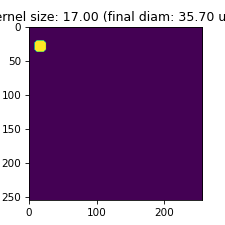

16
16


In [37]:
rid = 4
pl.figure(figsize=(3,3))
pl.imshow(dilated_masks[rid, :, :])
pl.title("Kernel size: %.2f (final diam: %.2f um)" % (kernel_size, kernel_diam_um))
x, y = np.where(dilated_masks[rid, :, :]>0)
print(x.max()-x.min())
print(y.max()-y.min())

#### PHASE to roi masks

In [38]:
df.dropna().shape

(218, 4)

In [62]:
abs_vmin, abs_vmax = (-np.pi, np.pi)

average_overlap=True

#### Neuropil masks
azim_phase_np, elev_phase_np = get_phase_masks(dilated_masks, df_neuropil['phase_az'], df_neuropil['phase_el'], 
                                               average_overlap=average_overlap, roi_list=None)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: Mean of empty slice


In [63]:
#### Neuropil:  Transform 2p fov
azim_phase_np_r = transform_2p_fov(azim_phase_np, pixel_size_ds, normalize=False)
elev_phase_np_r = transform_2p_fov(elev_phase_np, pixel_size_ds, normalize=False)

In [64]:
# roi_list1 = filt_az.dropna().index.tolist()
# roi_list2 = filt_el.dropna().index.tolist()
# roi_list = np.intersect1d(roi_list1, roi_list2)

roi_list = df.dropna().index.tolist()

In [65]:
# azim_phase_soma, elev_phase_soma = get_phase_masks(dilated_masks, df['phase_az'], df['phase_el'], 
#                                                    average_overlap=average_overlap, roi_list=roi_list)

# #### Soma:  Transform 2p fov
# azim_phase_soma_r = transform_2p_fov(azim_phase_soma, pixel_size_ds, normalize=False)
# elev_phase_soma_r = transform_2p_fov(elev_phase_soma, pixel_size_ds, normalize=False)

In [66]:
# azim_phase_soma_r.shape

In [67]:
#### Transform all masks to get CENTROIDs
# This is to replace 'azim_phase_soma' stuff -- better control of visualization for scatterplot

nrois_total = masks_soma.shape[0]
masks_r0 = np.dstack([transform_2p_fov(dilated_masks[i, :], pixel_size_ds, normalize=False) \
                     for i in range(nrois_total)]).T
masks_r = np.swapaxes(masks_r0, 1, 2) # [nrois, d1/rows/y, d2/cols]
masks_r.shape

(389, 1177, 972)

In [68]:
centroids = get_roi_centroids(masks_r)
# centroids['phase_az'] = filt_az
# centroids['phase_el'] = filt_el
retinodf = pd.concat([centroids, df], axis=1)
retinodf.head()

,x,y,phase_az,phase_el,mag_az,mag_el
0,1110,898,-0.060648,-0.341177,0.011085,0.021942
1,1114,909,1.712203,-0.102381,0.005692,0.013006
2,1082,936,NaN,NaN,0.004324,0.008304
3,1041,939,NaN,NaN,0.007038,0.006870
4,1105,860,NaN,NaN,0.017321,0.011351


In [45]:
retinodf.shape

(389, 6)

In [46]:

# smoothing ------------------
def smooth_neuropil(azim_r, smooth_fwhm=21):
    V=azim_r.copy()
    V[np.isnan(azim_r)]=0
    VV=ndimage.gaussian_filter(V,sigma=smooth_fwhm)

    W=0*azim_r.copy()+1
    W[np.isnan(azim_r)]=0
    WW=ndimage.gaussian_filter(W,sigma=smooth_fwhm)

    azim_smoothed = VV/WW
    return azim_smoothed


In [47]:
#### Load ROI image (std activity map)
imgs = glob.glob(os.path.join('%s*' % RETID['SRC'], 'std_images.tif'))[0]

orig_zimg = tf.imread(imgs)
orig_zimg = orig_zimg.mean(axis=0)
zimg_r = transform_2p_fov(orig_zimg, pixel_size)


In [48]:
import matplotlib as mpl

<IPython.core.display.Javascript object>


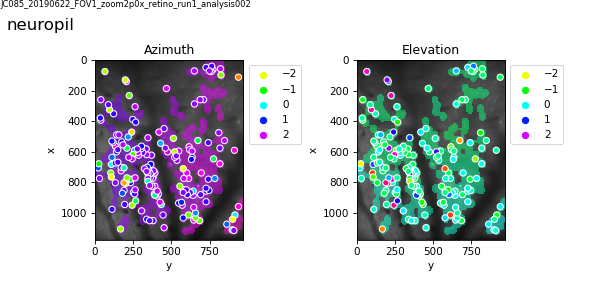

/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_f48037/visualization sanitycheck_centroids_vs_neuropil_masks


In [70]:
cmap='hsv'
plot_neuropil=True
mask_str='neuropil' if plot_neuropil else 'soma'

normalize = mpl.colors.Normalize(vmin=abs_vmin, vmax=abs_vmax)
# cmap = sns.color_palette('nipy_spectral')

fig, axn = pl.subplots(1, 2, figsize=(8,4))
ax = axn[0]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
if plot_neuropil:
    ax.imshow(azim_phase_np_r, cmap=cmap, vmin=abs_vmin, vmax=abs_vmax, alpha=0.5)
else:
    ax.imshow(azim_phase_soma_r, cmap=cmap, vmin=abs_vmin, vmax=abs_vmax, alpha=0.5)
sns.scatterplot(x='y', y='x', data=retinodf.loc[roi_list], 
                hue='phase_az', ax=ax, palette=cmap, alpha=1, hue_norm=normalize,
                linewidth=1, edgecolors='k')
ax.set_title("Azimuth")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

ax = axn[1]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
if plot_neuropil:
    ax.imshow(elev_phase_np_r, cmap=cmap, vmin=abs_vmin, vmax=abs_vmax, alpha=0.5)
else:
    ax.imshow(elev_phase_soma_r, cmap=cmap, vmin=abs_vmin, vmax=abs_vmax, alpha=0.5)
sns.scatterplot(x='y', y='x', data=retinodf.loc[roi_list], 
                hue='phase_el', ax=ax, palette=cmap, alpha=1, hue_norm=normalize,
                linewidth=1, edgecolors='k')
ax.set_title("Elevation")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
fig.text(0.01, 0.9, mask_str, fontsize=16)

label_figure(fig, data_id)
figname = 'sanitycheck_centroids_vs_%s_masks' % mask_str
pl.savefig(os.path.join(animal_dst_dir, '%s.svg' % figname)) 

print(animal_dst_dir, figname)

In [50]:
len(roi_list)

218

In [72]:
screen2p_x = 119.5564
screen2p_y = 67.323
resolution2p = [1920, 1080] #[1024, 768]

lmax_az_2p = screen2p_x/2.
lmin_az_2p = -lmax_az_2p
lmax_el_2p = screen2p_y/2.
lmin_el_2p = -lmax_el_2p

In [73]:

smooth_fwhm = 131 #21
#azim_smoothed = smooth_array(azim_smoothed, smooth_fwhm, phaseArray=True)
azim_smoothed = smooth_neuropil(azim_phase_np_r, smooth_fwhm=smooth_fwhm)
elev_smoothed = smooth_neuropil(elev_phase_np_r, smooth_fwhm=smooth_fwhm)



azi_2p_np = convert_range(azim_smoothed, newmin=lmin_azi, newmax=lmax_azi, oldmin=abs_vmin, oldmax=abs_vmax)
el_2p_np = convert_range(elev_smoothed, newmin=lmin_azi, newmax=lmax_azi, oldmin=abs_vmin, oldmax=abs_vmax)


In [74]:
retinodf['az_lin'] = convert_range(retinodf['phase_az'], newmin=lmin_az_2p, newmax=lmax_az_2p, 
                                   oldmin=abs_vmin, oldmax=abs_vmax)

retinodf['el_lin'] = convert_range(retinodf['phase_el'], newmin=lmin_az_2p, newmax=lmax_az_2p, 
                                   oldmin=abs_vmin, oldmax=abs_vmax)

<IPython.core.display.Javascript object>


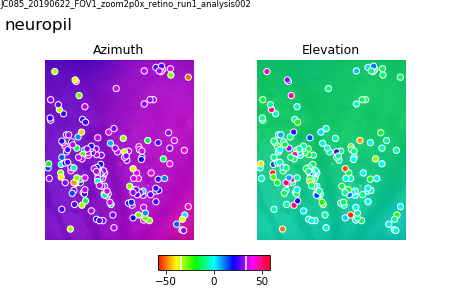

/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_f48037/visualization smoothed_np_retino_with_centroids_LIN


In [76]:
vmin = lmin_azi
vmax = lmax_azi

alpha=0.7

normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

fig, axn = pl.subplots(1, 2, figsize=(6,4))
ax = axn[0]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
ax.imshow(azi_2p_np, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
sns.scatterplot(x='y', y='x', data=retinodf.loc[roi_list], 
                hue='az_lin', ax=ax, palette=cmap, alpha=1, hue_norm=normalize,
                linewidth=1, edgecolors='k')
ax.set_title("Azimuth")
ax.legend_.remove()

ax = axn[1]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
im = ax.imshow(el_2p_np, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
sns.scatterplot(x='y', y='x', data=retinodf.loc[roi_list], 
                hue='el_lin', ax=ax, palette=cmap, alpha=1, hue_norm=normalize,
                linewidth=1, edgecolors='k')
ax.set_title("Elevation")
ax.legend_.remove()

pl.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.8, wspace=0.1)
fig.text(0.01, 0.9, mask_str, fontsize=16)

cb = fig.add_axes([0.35, 0.1, 0.25, 0.05])
pl.colorbar(im, cax=cb, orientation='horizontal')
screen_lim_pos = lmax_el_2p/lmax_az_2p #(lmax_alt-screen_h_max)/(lmax_alt*2.)
cb.axvline(x=screen_lim_pos*lmax_az_2p, color='w') # my data is between 0 and 1
cb.axvline(x=screen_lim_pos*lmin_az_2p, color='w') # my data is between 0 and 1
#cb.axvline(x=0, color='w')

for ax in axn.flat:
    ax.axis('off')

label_figure(fig, data_id)
figname = 'smoothed_np_retino_with_centroids_LIN'
pl.savefig(os.path.join(animal_dst_dir, '%s.svg' % figname)) 

print(animal_dst_dir, figname)

<IPython.core.display.Javascript object>


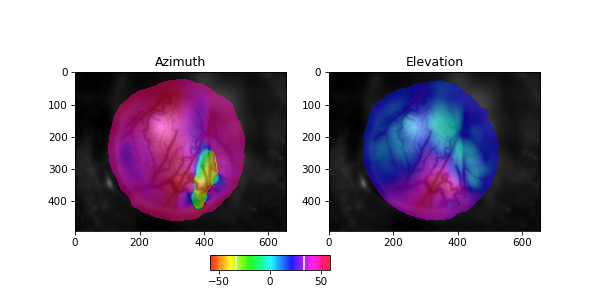

In [77]:
fig, axn = pl.subplots(1,2, figsize=(8,4))
ax=axn[0]
ax.set_title('Azimuth')
ax.imshow(surface_hd, cmap='gray')
im = ax.imshow(az_wf, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.5)
#pl.colorbar(im, orientation='horizontal', shrink=0.8)

ax=axn[1]
ax.set_title('Elevation')
ax.imshow(surface_hd, cmap='gray')
im1 = ax.imshow(el_wf, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.5)

cb = fig.add_axes([0.35, 0.1, 0.2, 0.05])
pl.colorbar(im, cax=cb, orientation='horizontal')

screen_lim_pos = screen_h_max/lmax_alt #(lmax_alt-screen_h_max)/(lmax_alt*2.)
cb.axvline(x=screen_lim_pos*lmax_alt, color='w') # my data is between 0 and 1
cb.axvline(x=screen_lim_pos*lmin_alt, color='w') # my data is between 0 and 1


<IPython.core.display.Javascript object>


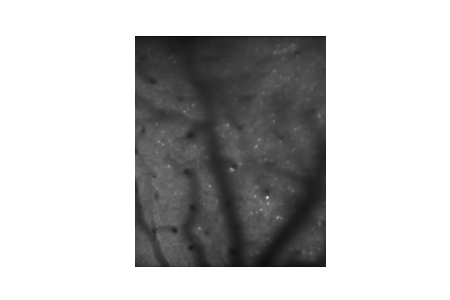

(-0.5, 971.5, 1176.5, -0.5)

In [78]:

fig, ax = pl.subplots(1, figsize=(6,4))
ax.imshow(zimg_r, cmap='gray') #, 
ax.axis('off')


# Plot example traces 

In [84]:
animal_dst_dir

'/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_f48037/visualization'

In [85]:
curr_dst_dir = os.path.join(animal_dst_dir, 'example_traces')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_f48037/visualization/example_traces


In [86]:
def plot_example_traces(soma_traces, np_traces, rid=0, cond='right',
                       soma_color='k', np_color='r', ax=None):
    
    if ax is None:
        fig, ax = pl.subplots()
    ax.plot(soma_traces[cond][rid], soma_color, label='soma')
    ax.plot(np_traces[cond][rid], np_color, label='neuropil')
    
    return ax

In [106]:
animalid, session, fov, retinorun_2p

('JC085', '20190620', 'FOV1_zoom2p0x', 'retino_run1')

In [119]:
# soma_traces = rutils.load_traces(animalid, session, fov, run=retinorun,
#                                   analysisid=retinoid, trace_type='raw')

soma_traces = load_roi_traces(animalid, session_2p, fov, run=retinorun_2p,
                 analysisid=retinoid, trace_type='corrected', detrend_after_average=True)

# Do fft

... loading traces (corrected)
... loading traces from: /n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_f48037


In [120]:
### Convert raw/processed traces to df/f
dff_soma = dict((cond, (tdf - tdf.mean(axis=0))/ tdf.mean(axis=0)) for cond, tdf in soma_traces.items())
#dff_np = dict((cond, (tdf - tdf.mean(axis=0))/ tdf.mean(axis=0)) for cond, tdf in np_traces.items())


In [121]:
# Get average across conditions
mean_phase_values_soma = phases_soma.mean(axis=1).values 

mean_magratio_values_soma = magratios_soma.mean(axis=1).values 
mean_magratio_values_np = magratios_np.mean(axis=1).values

# Sort ROIs by their average mag ratios
sorted_rois_soma = np.argsort(mean_magratio_values_soma)[::-1]
for roi in sorted_rois_soma[0:10]:
    print(roi, mean_magratio_values_soma[roi].round(3), mean_phase_values_soma[roi].round(3))

57 0.047 0.333
355 0.037 -1.513
39 0.034 -1.484
296 0.034 -1.627
175 0.03 0.235
346 0.029 0.919
36 0.028 -0.449
62 0.028 -0.675
98 0.027 -0.116
154 0.027 0.393


In [125]:
cycle_start_ixs = scaninfo['stimulus']['cycle_start_ixs']

In [139]:
fft_results['fft_soma'][cond][0][rid]

0.03642489987191137

In [143]:
    #n_cycles = int(round((n_frames/fr) / stimperiod))
    #n_frames_per_cycle = int(np.floor(stimperiod * fr))
    #cycle_starts = np.round(np.arange(0, n_frames_per_cycle * n_cycles, n_frames_per_cycle)).astype('int')

    n_frames = scaninfo['stimulus']['n_frames']
    fr = scaninfo['stimulus']['frame_rate']
    stimfreq= scaninfo['stimulus']['stim_freq']
    
    # Get frequency info
    freqs = np.fft.fftfreq(n_frames, float(1./fr))
    sorted_idxs = np.argsort(freqs)
    freqs = freqs[sorted_idxs] # sorted
    freqs = freqs[int(np.round(n_frames/2.))+1:] # exclude DC offset from data
    stim_freq_idx = np.argmin(np.absolute(freqs - stimfreq)) # Index of stimulation frequency

# get phase and magnitude
#     mag_data = abs(fft_results)
#     phase_data = np.angle(fft_results)

#     # sort mag and phase by freq idx:
#     mag_data = mag_data[sorted_idxs]
#     phase_data = phase_data[sorted_idxs]

In [146]:
dff_soma['right']

,0,1,2,3,4,5,6,7,8,9,...,379,380,381,382,383,384,385,386,387,388
0,0.030454,-0.022183,0.016519,-0.024162,0.039429,0.010090,0.023554,-0.044262,0.107970,0.004262,...,-0.004887,-0.026175,-0.009598,0.014556,0.042691,0.037574,-0.033181,-0.034620,-0.042614,0.001899
1,-0.010741,-0.033601,-0.009571,-0.019436,0.052933,-0.051841,0.002099,0.045514,0.023628,0.000928,...,0.057187,-0.016574,0.048963,0.046571,0.071248,-0.029463,-0.017396,-0.056942,0.028245,0.043054
2,-0.026251,-0.024088,-0.013787,-0.019242,0.056773,-0.014592,-0.034272,0.124724,-0.082242,-0.032612,...,0.067512,0.039968,0.023686,-0.017046,0.072058,-0.071362,0.018192,-0.043420,0.097125,0.017952
3,-0.006483,0.019679,0.047173,-0.001014,0.022528,0.060213,-0.065898,0.037053,-0.078339,-0.078899,...,0.026825,0.052921,-0.008868,-0.047961,-0.076030,0.014053,0.042603,-0.046059,0.047311,-0.058584
4,0.053892,0.010973,0.048029,0.007042,-0.021469,0.030573,-0.008507,-0.011294,-0.070109,-0.059269,...,0.001384,0.005612,0.013028,-0.054379,-0.064513,0.050365,0.048964,0.005869,0.023529,-0.006132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2228,-0.053603,0.063499,-0.059190,-0.016090,-0.031731,-0.027887,0.005503,-0.071198,-0.029230,0.037741,...,0.001188,-0.008258,-0.042227,-0.016719,0.012986,0.060209,-0.062503,-0.024644,0.004844,0.059263
2229,-0.033855,0.007832,-0.095593,0.045863,-0.007826,-0.002787,0.026533,-0.049578,-0.029850,0.116645,...,-0.018205,-0.035237,-0.032000,-0.017097,0.002369,0.067366,-0.032260,0.017501,-0.009297,0.027936
2230,0.022301,0.018406,-0.098344,0.054751,0.044258,0.014637,0.047460,0.051387,0.015807,0.111194,...,0.006863,-0.024257,-0.032271,0.003562,-0.077643,0.032712,0.005624,-0.010827,0.043950,-0.002012
2231,0.029666,-0.019277,-0.082055,-0.015314,0.018917,-0.029096,0.009512,0.086164,0.004038,0.068779,...,0.036425,0.042835,-0.025782,0.004888,-0.071613,-0.052577,-0.061107,-0.016638,0.047726,0.000482


In [214]:

def do_fft_return_arrray(avg_traces, sorted_idxs, stim_freq_idx):
    n_frames = avg_traces.shape[0]

    fft_results = np.fft.fft(avg_traces, axis=0) #avg_traces.apply(np.fft.fft, axis=1)

    # get phase and magnitude
    mag_data = abs(fft_results) #**2
    phase_data = np.angle(fft_results)

    # sort mag and phase by freq idx:
    mag_data = mag_data[sorted_idxs]
    phase_data = phase_data[sorted_idxs]

    # exclude DC offset from data
    #if len(mag_data.shape)==1:
    print("excl offset")
    mag_data = mag_data[int(np.round(n_frames/2.))+1:]
    phase_data = phase_data[int(np.round(n_frames/2.))+1:]
    
    return pd.DataFrame(mag_data), pd.DataFrame(phase_data)

In [215]:
marray, parray = do_fft_return_arrray(dff_soma['right'], sorted_idxs, stim_freq_idx)


excl offset


<IPython.core.display.Javascript object>


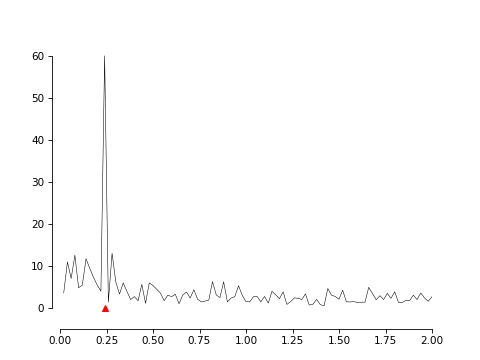

0.23996130765785936 0.23996130765785936


In [216]:
fig, ax = pl.subplots()

max_idx = marray[rid].argmax()
print(freqs[max_idx], freqs[stim_freq_idx])
label='Cell %i, max=%.2f Hz' % (rid, freqs[max_idx])
ax.plot(freqs, marray[rid], color='k', lw=0.5, label=label)
ax.plot(freqs[stim_freq_idx], 0, 'r^')
ax.set_xlim([0, 2])
sns.despine(trim=True, offset=8)

In [252]:
np.array(scaninfo['frame_nums']).astype(float)


array([1.000e+00, 2.000e+00, 3.000e+00, ..., 2.231e+03, 2.232e+03,
       2.233e+03])

In [261]:
import matplotlib.gridspec as gridspec
# Plotting
def label_figure(fig, data_identifier):
    fig.text(0, 1,data_identifier, ha='left', va='top', fontsize=8)

    

<IPython.core.display.Javascript object>


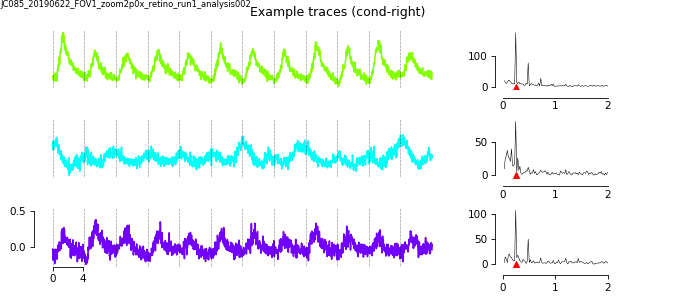

[]
[<AxesSubplot:>, <AxesSubplot:>]
[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]


In [263]:
plot_rois = [57, 355, 247] #, 346] #, id = sorted_rois_soma[0] #113
roi_colors = sns.color_palette(cmap, n_colors=len(plot_rois))
save_plot = True

cond='right'
time_sec = np.array(scaninfo['frame_nums']).astype(float) * (1./fr)
#fig, axn = pl.subplots(4, 1, sharex=True, sharey=True, figsize=(5, 6))

fig = pl.figure(figsize=(9,4))
gs = gridspec.GridSpec(len(plot_rois), 4) # sharex=True, sharey=True)


for ai, (col, rid) in enumerate(zip( roi_colors, plot_rois)):
    print(fig.axes)
    if ai==0:
        ax=fig.add_subplot(gs[ai, 0:3])
    else:
        ax=fig.add_subplot(gs[ai, 0:3], sharex=fig.axes[0], sharey=fig.axes[0])
    ax.plot(time_sec, dff_soma[cond][rid], color=col, label='soma')
    for cyc in cycle_start_ixs:
        ax.axvline(x=time_sec[cyc], linestyle=':', linewidth=0.5, color='k')
    if ai!=(len(plot_rois)-1):
        ax.axis('off')
    else:
        ax.set_xticks([0, 4])

    if ai==0:
        ax=fig.add_subplot(gs[ai, 3:])
    else:
        ax=fig.add_subplot(gs[ai, 3:], sharex=fig.axes[1]) #, sharey=fig.axes[1])
    max_idx = marray[rid].argmax()
    #print(freqs[max_idx], freqs[stim_freq_idx])
    label='Cell %i, max=%.2f Hz' % (rid, freqs[max_idx])
    ax.plot(freqs, marray[rid], color='k', lw=0.5, label=label)
    ax.plot(freqs[stim_freq_idx], 0, 'r^')
    ax.set_xlim([0, 2])
    sns.despine(trim=True, offset=8, ax=ax)
    if ai!=(len(plot_rois)-1):
        ax.tick_params(which='both', axis='x', size=0) #off')
        #ax.set_xticks([])

    
pl.subplots_adjust(left=0.05, right=0.9, hspace=0.5, top=0.9, wspace=0.5)
sns.despine(trim=True)

pl.suptitle('Example traces (cond-%s)' % cond)
label_figure(fig, data_id)


pl.savefig(os.path.join(curr_dst_dir, 'dff_traces_with_magspec.svg'))

In [247]:
time_sec

50.008062204385844

In [ ]:
azim_phase_mask_np = np.ma.masked_where(azim_phase_np==-100, azim_phase_np)
elev_phase_mask_np = np.ma.masked_where(elev_phase_np==-100, elev_phase_np)

azim_phase_mask_soma = np.ma.masked_where(azim_phase_soma==-100, azim_phase_soma)
elev_phase_mask_soma = np.ma.masked_where(elev_phase_soma==-100, elev_phase_soma)



In [32]:
import dill as pkl

In [35]:
# retmap_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper'
# fn = os.path.join(retmap_dir, 'JC085_20190620/20200601/20190620_MJC085_loadresults.pkl')

# with open(fn, 'rb') as f:
#     rmap = pkl.load(f)
    

In [38]:
# Load colormap
from matplotlib.colors import LinearSegmentedColormap

colormap = 'nic_Edge'
cmapdir = '/n/coxfs01/julianarhee/colormaps' #os.path.join(aggr_dir, 'colormaps')
cdata = np.loadtxt(os.path.join(cmapdir, colormap) + ".txt")
cmap_phase = LinearSegmentedColormap.from_list('my_colormap', cdata[::-1])


In [ ]:
outdir = os.path.join(aggregate_dir, 'retinotopy') #, 'figures', 'caiman-examples')
if not os.path.exists(outdir):
    os.makedirs(outdir)
outdir